## Import

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
import torch

In [3]:
# https://www.kaggle.com/datasets/benhamner/sf-bay-area-bike-share?select=status.csv
dataset_station_statut = pd.read_csv("../../../../Bike_Data/status.csv")
dataset_station = pd.read_csv("../../../../Bike_Data/station.csv")

## Class TimeSeriesDataset

In [4]:
# Define a PyTorch dataset to generate input/target pairs for the LSTM model
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size, stride, target_size=1, drop=None):
        self.data = data
        self.window_size = window_size
        self.stride = stride
        self.target_size = target_size
        self.drop = drop

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        inputs = self.data[idx:idx+self.window_size]
        target = self.data[idx+self.window_size:idx+self.window_size+self.target_size]
        if self.drop is not None:
            target = np.delete(target, self.drop, axis=1)
        return inputs, target

## Class LSTM v1

In [5]:
# Define your LSTM model here with num_layers LSTM layers and 1 fully connected layer
class LSTMModel_v1(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = torch.nn.LSTM(input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = torch.nn.Linear(self.hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## Station statut dataset

## Station dataset

In [6]:
dataset_station.head(3)

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013


In [7]:
dataset_station.shape

(70, 7)

## Merge dataset Station statut and Station

In [8]:
dataset = pd.merge(dataset_station, dataset_station_statut, left_on='id', right_on='station_id')

In [9]:
dataset.head(3)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:06:01
1,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:07:01
2,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:08:01


In [10]:
dataset.shape

(71984434, 11)

### See the mean variation for differents interval of time

In [11]:
dataset_station_statut_drop = dataset_station_statut.drop(["docks_available"], axis=1)
dataset_station_statut_drop['time'] = pd.to_datetime(dataset_station_statut_drop['time'], format="mixed")
pivoted_dataset_station_statut_drop = dataset_station_statut_drop.pivot_table(index='time', columns='station_id', values='bikes_available')

In [12]:
import pandas as pd

# assuming your dataframe is named df and has a datetime index
intervals = ['5min', '10min', '15min', '30min', '60min']
for interval in intervals:
    resampled = pivoted_dataset_station_statut_drop.resample(interval).var().mean().sort_values(ascending=False)
    print(f'Mean Variance for {interval} interval:')
    print(resampled)

Mean Variance for 5min interval:
station_id
70    0.227252
69    0.152443
50    0.144004
61    0.110123
60    0.104654
        ...   
33    0.006550
8     0.006083
23    0.005957
38    0.005068
5     0.004799
Length: 70, dtype: float64
Mean Variance for 10min interval:
station_id
70    0.500550
69    0.343188
50    0.317341
61    0.233667
60    0.210250
        ...   
8     0.011556
33    0.010267
5     0.008726
23    0.008316
38    0.007830
Length: 70, dtype: float64
Mean Variance for 15min interval:
station_id
70    0.783799
69    0.557002
50    0.492731
61    0.346430
65    0.325293
        ...   
8     0.016246
33    0.013776
5     0.012483
38    0.010602
23    0.010149
Length: 70, dtype: float64
Mean Variance for 30min interval:
station_id
70    1.463287
69    1.152336
50    1.010326
61    0.691692
65    0.667708
        ...   
5     0.024140
83    0.024065
33    0.023480
38    0.017727
23    0.014105
Length: 70, dtype: float64
Mean Variance for 60min interval:
station_id
70    2.

# 1/ (Mulivariate) Selection of n station to make prediction

### All id station available

In [13]:
print(dataset['id'].unique())
print(len(dataset['id'].unique()))

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 16 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 41 42 45 46 47 48 49 50 51 39 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 80 82 83 84]
70


#### Select stations

In [131]:
id_station = [42, 70, 60, 61, 45, 77, 69]

In [132]:
dataset_station_id = dataset.loc[dataset['id'].isin(id_station)]

In [133]:
dock_count = dataset_station_id['dock_count'].unique()
print(dock_count)

[15 27 23 19]


In [134]:
dataset_station_id.shape

(7329983, 11)

In [135]:
dataset_station_id.head(3)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
34204912,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:06:01
34204913,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:07:01
34204914,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:08:01


In [136]:
dataset_station_id.tail(3)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
68740952,77,Market at Sansome,37.789625,-122.400811,27,San Francisco,8/25/2013,77,13,14,2015-08-31 23:57:02
68740953,77,Market at Sansome,37.789625,-122.400811,27,San Francisco,8/25/2013,77,13,14,2015-08-31 23:58:02
68740954,77,Market at Sansome,37.789625,-122.400811,27,San Francisco,8/25/2013,77,13,14,2015-08-31 23:59:02


### Drop columns

In [137]:
dataset_station_id_drop = dataset_station_id.drop(["name", 'lat', 'long', 'id', 'city', 'installation_date', "docks_available", "dock_count"], axis=1)

In [138]:
dataset_station_id_drop.head(1)

,station_id,bikes_available,time
34204912,42,7,2013/08/29 12:06:01


### Check presence of null and NaN values

In [139]:
dataset_station_id_drop.isna().sum()

station_id         0
bikes_available    0
time               0
dtype: int64

In [140]:
dataset_station_id_drop[dataset_station_id_drop.isna().any(axis=1)]

,station_id,bikes_available,time


In [141]:
dataset_station_id_drop.dtypes

station_id          int64
bikes_available     int64
time               object
dtype: object

### Conversion column time to datetime

In [142]:
dataset_station_id_drop['time'] = pd.to_datetime(dataset_station_id_drop['time'], format="mixed")

In [143]:
dataset_station_id_drop.dtypes

station_id                  int64
bikes_available             int64
time               datetime64[ns]
dtype: object

In [144]:
dataset_station_id_drop.head(1)

,station_id,bikes_available,time
34204912,42,7,2013-08-29 12:06:01


In [145]:
dataset_station_id_drop.tail(1)

,station_id,bikes_available,time
68740954,77,13,2015-08-31 23:59:02


### Train

In [146]:
def plot_loss_valid(valid_losses):
    plt.plot(valid_losses, label = 'Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.show()

In [147]:
# Train your model and evaluate on the validation set
def train_model(model, optimizer, criterion, train_loader, valid_loader, num_epochs):
    num_epochs = num_epochs
    best_val_loss = float('inf')
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.squeeze(dim=(1)).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_losses.append(loss.item())
        val_loss = 0.0
    
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.squeeze(dim=(1)).float())
            val_loss += loss.item()
        
        val_loss /= len(valid_loader)
        valid_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_LSTM.pth')
    
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
    plot_loss_valid(valid_losses)
    
    

### Test

In [148]:
def test_model(best_model, test_loader, criterion):
    # Load the best model and evaluate on the test set
    best_model.double()
    best_model.eval()

    # Evaluate the model on the test set
    test_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = best_model(inputs)
            loss = criterion(outputs, targets.squeeze(dim=(1)))
            test_loss += loss.item()
            # Save the predictions and actual values for plotting later
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.squeeze(dim=(1)).cpu().numpy())
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    # Concatenate the predictions and actuals
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    return (predictions, actuals)

In [149]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

### Print Global Metrics 

In [150]:
def result_prediction(predictions, actuals):
    indices_by_month = []
    EPSILON = 1e-5
    # Créer une liste vide pour stocker les données du tableau
    data = []
    for i in range(1): 
        y_pred = predictions[:,i]
        y_true = actuals[:,i]

        signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred)*100
        if (mape > 1 or mape < 0):
            mape = "ERROR"
        smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
        maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

        # Ajouter une ligne au tableau avec le nom du mois et les metrics
        data.append(["Global", signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Global', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Global', inplace=True)
    # Retourner le DataFrame
    return df

### Print Metrics for each month

In [151]:
def result_prediction_by_month(predictions, actuals):
    indices_by_month = []
    EPSILON = 1e-5
    # Créer une liste vide pour stocker les données du tableau
    data = []
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='M'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_month.append((name.strftime('%B'), indices))

        for name, indice in indices_by_month:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]

            signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mape = mean_absolute_percentage_error(y_true, y_pred)*100
            if (mape > 1 or mape < 0):
                mape = "ERROR"
            smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
            maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

            # Ajouter une ligne au tableau avec le nom du mois et les metrics
            data.append([name, signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Month', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Month', inplace=True)
    # Retourner le DataFrame
    return df

### Print Metrics for each week

In [152]:
def result_prediction_by_week(predictions, actuals):
    indices_by_week = []
    EPSILON = 1e-5
    
    data = []
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='W'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_week.append((name.strftime('%W'), indices))

        for name, indice in indices_by_week:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]

            signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mape = mean_absolute_percentage_error(y_true, y_pred)*100
            if (mape > 1 or mape < 0):
                    mape = "ERROR"
            smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
            maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

            # Ajouter une ligne au tableau avec le nom du mois et les metrics
            data.append([name, signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Week', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Week', inplace=True)
    # Retourner le DataFrame
    return df

### Print Metrics for each day

In [153]:
def result_prediction_by_day(predictions, actuals):
    indices_by_day = []
    EPSILON = 1e-5
    
    data = []
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='D'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_day.append((name.timetuple().tm_yday, indices))

        for name, indice in indices_by_day:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]

            signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mape = mean_absolute_percentage_error(y_true, y_pred)*100
            if (mape > 1 or mape < 0):
                mape = "ERROR"
            smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
            maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

            # Ajouter une ligne au tableau avec le nom du mois et les metrics
            data.append([name, signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Day', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Day', inplace=True)
    # Retourner le DataFrame
    return df

### Print Metrics for each hour

In [154]:
def result_prediction_by_hour(predictions, actuals):
    indices_by_hour = []
    EPSILON = 1e-5
    
    data = []
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='H'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_hour.append((name, indices))

        for name, indice in indices_by_hour:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]
            if len(y_pred) != 0 and len(y_true != 0) :
                signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
                mae = mean_absolute_error(y_true, y_pred)
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                mape = mean_absolute_percentage_error(y_true, y_pred)*100
                if (mape > 1 or mape < 0):
                    mape = "ERROR"
                smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
                maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

                # Ajouter une ligne au tableau avec le nom du mois et les metrics
                data.append([f'{name.timetuple().tm_yday} / {name.hour}', signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Day / Hour', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Day / Hour', inplace=True)
    # Retourner le DataFrame
    return df

## Trying to forecast the availability of bikes 

In [155]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [156]:
pivoted_df_station_id = dataset_station_id_drop.pivot_table(index='time', columns='station_id', values='bikes_available')

In [157]:
pivoted_df_station_id.head(10)

station_id,42,45,60,61,69,70,77
time,,,,,,,
2013-08-29 12:06:01,7.0,11.0,8.0,11.0,4.0,0.0,14.0
2013-08-29 12:07:01,7.0,11.0,8.0,11.0,4.0,0.0,14.0
2013-08-29 12:08:01,7.0,11.0,8.0,11.0,4.0,0.0,14.0
2013-08-29 12:09:01,7.0,11.0,8.0,11.0,4.0,0.0,14.0
2013-08-29 12:10:01,7.0,11.0,8.0,11.0,4.0,0.0,14.0
2013-08-29 12:11:01,7.0,11.0,8.0,11.0,4.0,0.0,11.0
2013-08-29 12:12:01,7.0,11.0,8.0,11.0,4.0,0.0,11.0
2013-08-29 12:13:01,7.0,11.0,8.0,11.0,4.0,0.0,10.0
2013-08-29 12:15:01,7.0,11.0,8.0,11.0,4.0,0.0,10.0


### First Experimentation

#### Use 15 min to predict the 5th next min

In [158]:
df_weekday_hour = pivoted_df_station_id.groupby(pd.Grouper(freq='5min'), dropna=True).mean()

In [159]:
# window_size = "10min"
# df_weekday_hour = group.rolling(window_size).mean()

In [160]:
len(df_weekday_hour[df_weekday_hour.isna().any(axis=1)])    

752

In [161]:
df_weekday_hour = df_weekday_hour.dropna()

In [162]:
len(df_weekday_hour[df_weekday_hour.isna().any(axis=1)])

0

In [163]:
df_weekday_hour_prep = df_weekday_hour.copy()

In [164]:
df_weekday_hour_prep.head(4)

station_id,42,45,60,61,69,70,77
time,,,,,,,
2013-08-29 12:05:00,7.0,11.0,8.0,11.0,4.0,0.00,14.0
2013-08-29 12:10:00,7.0,11.0,8.0,11.0,4.0,0.00,11.5
2013-08-29 12:15:00,7.0,11.5,8.5,11.0,4.0,0.25,10.0
2013-08-29 12:20:00,7.0,12.0,9.5,11.0,4.0,1.00,10.5


In [165]:
df_weekday_hour_prep[df_weekday_hour_prep.isna().any(axis=1)]

station_id,42,45,60,61,69,70,77
time,,,,,,,


In [166]:
train_data = df_weekday_hour_prep[:'2014-11-01 12:00:00']
valid_data = df_weekday_hour_prep['2014-11-01 12:00:00':'2015-01-01 12:00:00']
test_data = df_weekday_hour_prep['2015-01-01 12:00:00':'2015-08-31 13:00:00']

##### f(a(t), b(t), c(t)) = a(t+1), b(t+1) + c(t+1)

In [167]:
# Define the sliding window size and stride
window_size = 3
stride = 1

# Create datasets and data loaders for training, validation, and test sets
train_dataset = TimeSeriesDataset(train_data.values, window_size, stride)
valid_dataset = TimeSeriesDataset(valid_data.values, window_size, stride)
test_dataset = TimeSeriesDataset(test_data.values, window_size, stride)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [168]:
# Parameters of the LSTM
layers = 3
hidden_size = 32
input_LSTM = len(id_station)
output_LSTM = len(id_station)

# Instantiate your LSTM model and define the loss function and optimizer
model = LSTMModel_v1(input_size=input_LSTM, hidden_size=hidden_size, num_layers=layers, output_size=output_LSTM)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/50, Training Loss: 80112.4618, Validation Loss: 14.7247
Epoch 2/50, Training Loss: 47899.5082, Validation Loss: 10.1692
Epoch 3/50, Training Loss: 27903.1483, Validation Loss: 5.3256
Epoch 4/50, Training Loss: 18094.8142, Validation Loss: 3.7432
Epoch 5/50, Training Loss: 12857.3329, Validation Loss: 2.4634
Epoch 6/50, Training Loss: 8118.9035, Validation Loss: 1.7240
Epoch 7/50, Training Loss: 4966.2029, Validation Loss: 1.1239
Epoch 8/50, Training Loss: 3778.3527, Validation Loss: 1.0550
Epoch 9/50, Training Loss: 3315.7249, Validation Loss: 0.9426
Epoch 10/50, Training Loss: 3008.1476, Validation Loss: 0.8572
Epoch 11/50, Training Loss: 2799.8465, Validation Loss: 0.8351
Epoch 12/50, Training Loss: 2673.6586, Validation Loss: 0.7658
Epoch 13/50, Training Loss: 2574.2569, Validation Loss: 0.8231
Epoch 14/50, Training Loss: 2511.3429, Validation Loss: 0.8453
Epoch 15/50, Training Loss: 2450.0076, Validation Loss: 0.8072
Epoch 16/50, Training Loss: 2382.6807, Validation Loss: 0

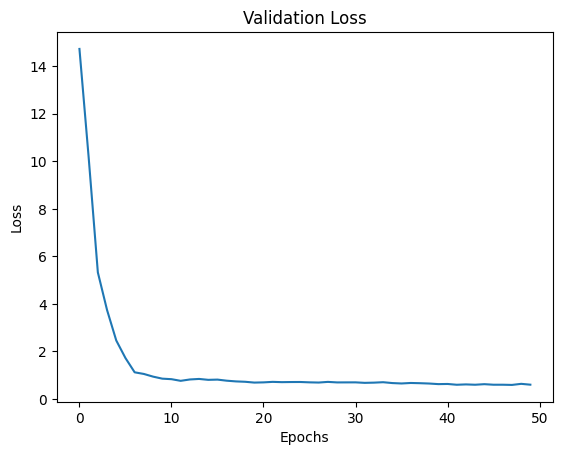

In [169]:
train_model(model, optimizer, criterion, train_loader, valid_loader, 50)

In [170]:
best_model =  LSTMModel_v1(input_size=input_LSTM, hidden_size=hidden_size, num_layers=layers, output_size=output_LSTM)
best_model.load_state_dict(torch.load('best_model_LSTM.pth'.format(input)))
predictions_n_to_n, actuals_n_to_n = test_model(best_model, test_loader, criterion)

Test Loss: 0.6826


In [171]:
results_global_n_to_n =  result_prediction(predictions_n_to_n, actuals_n_to_n)
results_global_n_to_n

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Global,,,,,,
Global,-,0.357496,0.545772,ERROR,9.363695,8.710732


In [172]:
results_month_n_to_n = result_prediction_by_month(predictions_n_to_n, actuals_n_to_n)
results_month_n_to_n

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Month,,,,,,
January,-,0.298352,0.480379,ERROR,6.609863,6.252080
February,-,0.326997,0.498287,ERROR,9.724017,8.899981
March,-,0.380065,0.562640,ERROR,9.416661,8.825969
April,-,0.372298,0.555458,ERROR,10.106176,9.317217
May,-,0.398187,0.556266,ERROR,12.143561,11.528719
June,-,0.370272,0.583642,ERROR,10.137600,9.243585
July,-,0.380271,0.581356,ERROR,8.172771,7.712524
August,-,0.330227,0.535469,ERROR,8.627413,7.908230


In [173]:
results_week_n_to_n = result_prediction_by_week(predictions_n_to_n, actuals_n_to_n)
results_week_n_to_n

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Week,,,,,,
00,-,0.158170,0.235759,ERROR,2.145747,2.120985
01,-,0.347899,0.468905,ERROR,8.402884,7.863499
02,-,0.281509,0.487190,ERROR,7.141736,6.650842
03,-,0.294984,0.519018,ERROR,5.249575,5.108378
04,-,0.339475,0.518711,ERROR,7.510542,7.119280
05,-,0.332436,0.486720,ERROR,9.483213,8.750308
06,-,0.342625,0.590742,ERROR,9.819129,8.888508
07,-,0.300845,0.445877,ERROR,7.949397,7.623448
08,-,0.369741,0.497788,ERROR,12.885878,11.423306


In [174]:
results_day_n_to_n = result_prediction_by_day(predictions_n_to_n, actuals_n_to_n)
results_day_n_to_n

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Day,,,,,,
1,-,0.101850,0.231450,ERROR,1.765104,1.692495
2,-,0.179805,0.252506,ERROR,2.092297,2.058433
3,-,0.148300,0.218663,ERROR,1.863643,1.863646
4,-,0.174565,0.237025,ERROR,2.671624,2.655120
5,+,0.361026,0.531270,ERROR,11.778606,10.764757
...,...,...,...,...,...,...
239,-,0.521365,0.687000,ERROR,11.199968,10.407104
240,-,0.329794,0.539410,ERROR,7.896342,7.232729
241,-,0.286706,0.394425,ERROR,3.959852,3.926720


In [175]:
results_hour_n_to_n = result_prediction_by_hour(predictions_n_to_n, actuals_n_to_n)
results_hour_n_to_n

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Day / Hour,,,,,,
1 / 12,-,0.100634,0.138634,ERROR,1.574523,1.554490
1 / 13,-,0.085487,0.106179,ERROR,2.170917,2.136229
1 / 14,-,0.369669,0.638857,ERROR,7.568030,6.827134
1 / 15,+,0.139274,0.279222,ERROR,2.200793,2.271485
1 / 16,-,0.197124,0.328045,ERROR,2.933829,2.806365
...,...,...,...,...,...,...
243 / 9,-,0.779116,1.061842,ERROR,8.571680,8.051291
243 / 10,-,1.050562,1.080989,ERROR,8.176544,7.999012
243 / 11,+,0.174011,0.270884,ERROR,1.956331,1.997664


In [176]:
results_global_n_to_n.to_csv(f"results_global_n_to_n_station_{len(id_station)}.csv")
results_month_n_to_n.to_csv(f"results_month_n_to_n_station_{len(id_station)}.csv")
results_week_n_to_n.to_csv(f"results_week_n_to_n_station_{len(id_station)}.csv")
results_day_n_to_n.to_csv(f"results_day_n_to_n_station_{len(id_station)}.csv")
results_hour_n_to_n.to_csv(f"results_hour_n_to_n_station_{len(id_station)}.csv")

##### f(a(t), b(t), c(t)) = a(t+1)

In [177]:
df_weekday_hour_prep.head(3)

station_id,42,45,60,61,69,70,77
time,,,,,,,
2013-08-29 12:05:00,7.0,11.0,8.0,11.0,4.0,0.00,14.0
2013-08-29 12:10:00,7.0,11.0,8.0,11.0,4.0,0.00,11.5
2013-08-29 12:15:00,7.0,11.5,8.5,11.0,4.0,0.25,10.0


In [178]:
# Define the sliding window size and stride
window_size = 3
stride = 1
drop_columns = [i for i in range(1, len(id_station))]

# Create datasets and data loaders for training, validation, and test sets
train_dataset = TimeSeriesDataset(train_data.values, window_size, stride, drop=drop_columns)
valid_dataset = TimeSeriesDataset(valid_data.values, window_size, stride, drop=drop_columns)
test_dataset = TimeSeriesDataset(test_data.values, window_size, stride, drop=drop_columns)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [179]:
# Parameters of the LSTM
layers = 3
hidden_size = 32
input_LSTM = len(id_station)
output_LSTM = 1

# Instantiate your LSTM model and define the loss function and optimizer
model = LSTMModel_v1(input_size=input_LSTM, hidden_size=hidden_size, num_layers=layers, output_size=output_LSTM)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/100, Training Loss: 14013.8119, Validation Loss: 0.4990
Epoch 2/100, Training Loss: 1215.3364, Validation Loss: 0.3366
Epoch 3/100, Training Loss: 1013.1509, Validation Loss: 0.1808
Epoch 4/100, Training Loss: 890.5913, Validation Loss: 0.1998
Epoch 5/100, Training Loss: 798.7947, Validation Loss: 0.1782
Epoch 6/100, Training Loss: 720.8295, Validation Loss: 0.2128
Epoch 7/100, Training Loss: 736.1143, Validation Loss: 0.1962
Epoch 8/100, Training Loss: 695.6945, Validation Loss: 0.1816
Epoch 9/100, Training Loss: 711.3723, Validation Loss: 0.2062
Epoch 10/100, Training Loss: 652.3107, Validation Loss: 0.2239
Epoch 11/100, Training Loss: 655.1732, Validation Loss: 0.2124
Epoch 12/100, Training Loss: 649.3285, Validation Loss: 0.2358
Epoch 13/100, Training Loss: 638.2300, Validation Loss: 0.1948
Epoch 14/100, Training Loss: 658.9645, Validation Loss: 0.2442
Epoch 15/100, Training Loss: 649.4274, Validation Loss: 0.2537
Epoch 16/100, Training Loss: 648.1077, Validation Loss: 0.17

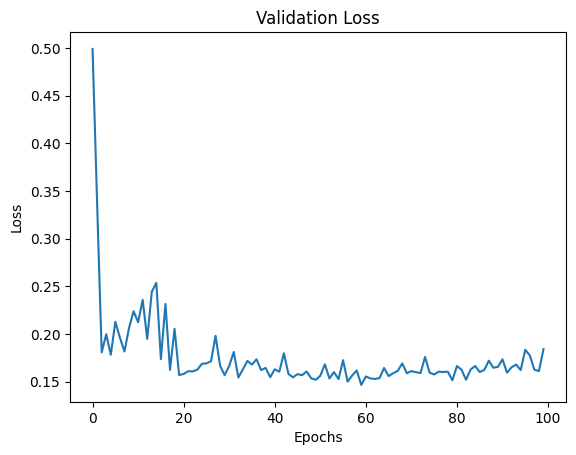

In [180]:
train_model(model, optimizer, criterion, train_loader, valid_loader, 100)

In [181]:
best_model =  LSTMModel_v1(input_size=input_LSTM, hidden_size=32, num_layers=layers, output_size=output_LSTM)
best_model.load_state_dict(torch.load('best_model_LSTM.pth'.format(input)))
predictions_n_to_1, actuals_n_to_1 = test_model(best_model, test_loader, criterion)

Test Loss: 0.1788


In [182]:
result_global_n_to_1 = result_prediction(predictions_n_to_1, actuals_n_to_1)
result_global_n_to_1

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Global,,,,,,
Global,+,0.201189,0.422729,ERROR,5.817528,5.277325


In [183]:
results_month_n_to_1 = result_prediction_by_month(predictions_n_to_1, actuals_n_to_1)
results_month_n_to_1

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Month,,,,,,
January,+,0.160335,0.374101,ERROR,4.020401,3.735438
February,+,0.170212,0.367701,ERROR,5.132785,4.723264
March,+,0.228875,0.449199,ERROR,6.203667,5.742496
April,+,0.212412,0.429638,ERROR,6.690141,6.009380
May,+,0.190583,0.398681,ERROR,6.263918,5.611842
June,+,0.214834,0.469382,ERROR,7.016957,6.259844
July,-,0.228179,0.448228,ERROR,5.028695,4.632175
August,+,0.201464,0.430124,ERROR,6.167827,5.490269


In [184]:
results_week_n_to_1 = result_prediction_by_week(predictions_n_to_1, actuals_n_to_1)
results_week_n_to_1

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Week,,,,,,
00,+,0.089938,0.178228,ERROR,1.272218,1.275041
01,+,0.147772,0.311134,ERROR,4.698286,4.202708
02,+,0.158038,0.398037,ERROR,4.279556,3.873308
03,+,0.165343,0.413002,ERROR,3.184590,3.119275
04,+,0.200243,0.416753,ERROR,4.954567,4.679417
05,-,0.158854,0.356151,ERROR,3.992667,3.822180
06,+,0.190379,0.426276,ERROR,5.719694,5.185099
07,+,0.171623,0.352913,ERROR,5.106748,4.754632
08,-,0.149749,0.324469,ERROR,5.644441,5.063894


In [185]:
results_day_n_to_1 = result_prediction_by_day(predictions_n_to_1, actuals_n_to_1)
results_day_n_to_1

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Day,,,,,,
1,+,0.100774,0.211911,ERROR,1.637121,1.600440
2,+,0.073685,0.171600,0.872664,0.873355,0.871687
3,+,0.096158,0.180125,ERROR,1.322090,1.340039
4,+,0.094551,0.163808,ERROR,1.438757,1.450696
5,+,0.214035,0.421823,ERROR,7.070986,6.538427
...,...,...,...,...,...,...
239,-,0.304117,0.512303,ERROR,4.936482,4.877185
240,-,0.249787,0.488875,ERROR,5.752588,5.503578
241,+,0.100487,0.221971,ERROR,1.425436,1.428249


In [186]:
results_hour_n_to_1 = result_prediction_by_hour(predictions_n_to_1, actuals_n_to_1)
results_hour_n_to_1

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Day / Hour,,,,,,
1 / 12,-,0.107191,0.133920,ERROR,1.659048,1.663096
1 / 13,+,0.071606,0.074267,ERROR,1.773101,1.789923
1 / 14,-,0.263629,0.537435,ERROR,5.028630,4.535079
1 / 15,+,0.126661,0.310010,ERROR,1.980366,2.080775
1 / 16,-,0.135945,0.306372,ERROR,2.037857,1.933065
...,...,...,...,...,...,...
243 / 9,-,0.737532,1.019950,ERROR,8.622027,8.067622
243 / 10,-,0.732056,0.845825,ERROR,5.828463,5.872284
243 / 11,+,0.191316,0.277931,ERROR,2.154840,2.186334


In [187]:
result_global_n_to_1.to_csv(f"results_global_n_to_1_station_{len(id_station)}.csv")
results_month_n_to_1.to_csv(f"results_month_n_to_1_station_{len(id_station)}.csv")
results_week_n_to_1.to_csv(f"results_week_n_to_1_station_{len(id_station)}.csv")
results_day_n_to_1.to_csv(f"results_day_n_to_1_station_{len(id_station)}.csv")
results_hour_n_to_1.to_csv(f"results_hour_n_to_1_station_{len(id_station)}.csv")